In [72]:
import numpy as np
import pandas as pd
import nltk

In [73]:
dataset = pd.read_csv('dataset/spam.csv', encoding='latin-1')
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [74]:
dataset.shape

(5572, 5)

In [75]:
dataset.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [76]:
drop_columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
dataset.drop(columns=drop_columns, inplace=True)

In [77]:
dataset.rename(columns={'v1':'label', 'v2': 'text'}, inplace=True)

In [78]:
dataset['label'] = dataset['label'].apply(lambda x: 0 if x == 'ham' else 1)
dataset.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [79]:
dataset.duplicated().sum()

403

In [80]:
dataset = dataset.drop_duplicates(keep='first')
dataset.shape

(5169, 2)

In [81]:
dataset['label'].value_counts()

label
0    4516
1     653
Name: count, dtype: int64

In [82]:
dataset['num_characters'] = dataset['text'].apply(len)

In [83]:
dataset['num_words'] = dataset['text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [84]:
dataset[['num_characters', 'num_words']].describe()

,num_characters,num_words
count,5169.000000,5169.000000
mean,78.977945,18.455794
std,58.236293,13.324758
min,2.000000,1.000000
25%,36.000000,9.000000
50%,60.000000,15.000000
75%,117.000000,26.000000
max,910.000000,220.000000


In [85]:
dataset.head()

,label,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sequence_word_counts(sequences):
    word_counts = [len(sequence.split()) for sequence in sequences]

    min_length_index = word_counts.index(min(word_counts))
    max_length_index = word_counts.index(max(word_counts))

    print("Sequence with minimum length:", len(sequences[min_length_index]), " - index: ", min_length_index)
    print("Sequence with maximum length:", len(sequences[max_length_index]), " - index: ", max_length_index)
    print("Sequence average length: ", sum(word_counts)/len(sequences))

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(word_counts, bins=20, kde=False, color="skyblue")
    
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.title("Histogram of Word Counts for Sequences")
    plt.show()

Sequence with minimum length: 3  - index:  256
Sequence with maximum length: 910  - index:  1059
Sequence average length:  15.34068485200232


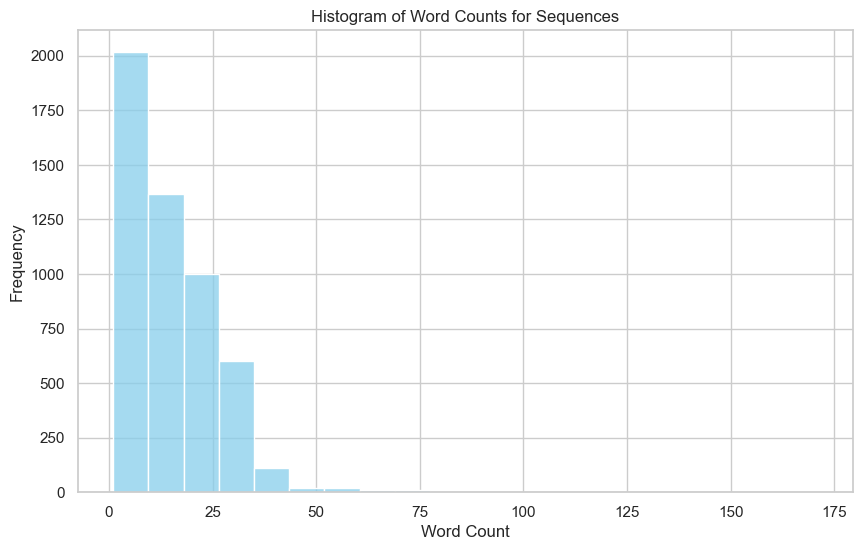

In [87]:
plot_sequence_word_counts(dataset['text'].tolist())


In [ ]:
import numpy as np
import pandas as pd
import os
import nltk
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from transformers import BertTokenizer, TFBertModel
from gensim.utils import simple_preprocess
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight


In [89]:
class BuildModel:
    def __init__(self, raw_train, raw_test):
        self.raw_train = raw_train
        self.raw_test = raw_test
        self.labels = ['Not SPAM', 'SPAM']
        self.savepath = 'savedfiles'
        
        self.bert_dense_model = None
        self.train_history = {}
        
        self.bert_tokenizer = None
        self.bert_model = None
        
        self.model_name = 'bert-base-uncased'
        self.EPOCHS = 10
        self.MAX_SEQUENCE_LENGTH = 50
        self.class_weights = None
        
        nltk.download('stopwords')
        self.stop_words = set(nltk.corpus.stopwords.words('english'))
        
    def prepare_dataset(self):
        print('Training Dataset -', self.raw_train['label'].value_counts())
        self.X_train_raw = self.raw_train['text'].tolist()
        y_train_raw = self.raw_train['label'].tolist()
        
        # One hot encoding
        self.y_train_raw = [[0, 0] for _ in range(len(y_train_raw))]
        for i, j in enumerate(y_train_raw):
            self.y_train_raw[i][j] = 1
        self.y_train_raw = np.array(self.y_train_raw, dtype=np.float32)
        
        print('Train data shape - ', self.raw_train.shape)
        
        print('Test Dataset -', self.raw_test['label'].value_counts())
        self.X_test_raw = self.raw_test['text'].tolist()
        y_test_raw = self.raw_test['label'].tolist()
        
        # One hot encoding
        self.y_test_raw = [[0, 0] for _ in range(len(y_test_raw))]
        for i, j in enumerate(y_test_raw):
            self.y_test_raw[i][j] = 1
        self.y_test_raw = np.array(self.y_test_raw, dtype=np.float32)
        
        # Compute class weights from integer labels
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array([0, 1]),
            y=y_train_raw
        )
        self.class_weights = dict(enumerate(class_weights))
        print("Class Weights - ", class_weights)
        
        print('Test data shape - ', self.raw_test.shape)
        
    def prepare_bert_tokens(self):
        if not self.bert_model or not self.bert_tokenizer:
            self.bert_model, self.bert_tokenizer = self.load_bert_model()
            print("Loaded Bert Model and Tokenizer.")
        else:
            print("Bert Model and Tokenizer already loaded.")
        
        self.X_train_bert_tokens = self.get_bert_tokens(self.X_train_raw)
        self.X_test_bert_tokens = self.get_bert_tokens(self.X_test_raw)
        
        print("Bert Tokens prepared")
        
    def load_bert_model(self):
        tokenizer = BertTokenizer.from_pretrained(self.model_name)
        model = TFBertModel.from_pretrained(self.model_name)
        model.trainable = False
        
        return model, tokenizer
    
    
    def get_bert_tokens(self, texts):
        texts = [self.seq_preprocess(seq) for seq in texts]
        ct = len(texts)

        input_ids = np.ones((ct, self.MAX_SEQUENCE_LENGTH), dtype='int32')
        
        # attntion mask tells BERT which tokens are real input and which are padding.
        attention_mask = np.zeros((ct, self.MAX_SEQUENCE_LENGTH), dtype='int32')
        token_type_ids = np.zeros((ct, self.MAX_SEQUENCE_LENGTH), dtype='int32')
        
        for k, text in tqdm(enumerate(texts), total = len(texts)):
            # Tokenize
            tok_text = self.bert_tokenizer.tokenize(text)
            
            # Truncate and convert tokens to numerical IDs
            enc_text = self.bert_tokenizer.convert_tokens_to_ids(tok_text[:(self.MAX_SEQUENCE_LENGTH-2)])
            
            input_length = len(enc_text) + 2
            input_length = input_length if input_length < self.MAX_SEQUENCE_LENGTH else self.MAX_SEQUENCE_LENGTH
            
            # Add tokens [CLS] and [SEP] at the begining and the end
            input_ids[k, :input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
            
            attention_mask[k, :input_length] = 1
        
        return {
                'input_word_ids':tf.constant(input_ids),
                'input_mask': tf.constant(attention_mask),
                'input_type_ids': tf.constant(token_type_ids)
            }
        
    def seq_preprocess(self, sentence):
        processed_words = simple_preprocess(sentence)
        processed_words = [word.lower() for word in processed_words if word.lower() not in self.stop_words]
        
        return ' '.join(processed_words)
    
    def train_dense_model(self, layers: int = 3, units: int = 200):
        input_word_ids = tf.keras.Input(shape=(self.MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_word_ids')
        input_mask = tf.keras.Input(shape=(self.MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_mask')
        input_type_ids = tf.keras.Input(shape=(self.MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_type_ids')
        
        x = self.bert_model.bert(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)
        x = x[0]
        
        for _ in range(layers):
            x = Dense(units, activation='relu')(x)
        x = Flatten()(x)
        x = Dense(2, activation='softmax')(x)
        
        self.bert_dense_model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        
        self.bert_dense_model.compile(loss='binary_crossentropy',
                                        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                                        metrics=['accuracy'])
        
        print("Model compiled with summary ----")
        print(self.bert_dense_model.summary())
        
        self.train_history['bert_dense'] = self.bert_dense_model.fit(self.X_train_bert_tokens, self.y_train_raw, epochs=self.EPOCHS,     class_weight=self.class_weights)
        
    def evaluate_model(self, model):
        try:
            y_test = self.y_test_raw
            y_pred = np.round(model.predict(self.X_test_bert_tokens))
            
            # Decode from one-hot to single class labels
            # y_test_labels = np.argmax(self.y_test_raw, axis=1)
            # y_pred_labels = np.argmax(y_pred, axis=1)
            # print(y_test_labels[:10])
            # print(y_pred_labels[:10])
            
            accuracy = accuracy_score(y_test[:, 0], y_pred[:, 0])
            precision = precision_score(y_test[:, 0], y_pred[:, 0])
            recall = recall_score(y_test[:, 0], y_pred[:, 0])
                
            print("Accuracy - ", accuracy)
            print("Precision - ", precision)
            print("Recall - ", recall)
                
        except Exception as e:
            print(e)
            
    def predict(self, msg):
        inputs = self.get_bert_tokens([msg])
        y_pred = np.round(self.bert_dense_model.predict(inputs))
        label_idx = np.argmax(y_pred, axis=1)[0]
        
        print(self.labels[label_idx])

    
    def save_files(self):
        os.makedirs(self.savepath, exist_ok=True)
        self.bert_dense_model.save(f'{self.savepath}/bert_dense_model.h5')
        self.bert_tokenizer.save_pretrained(f'{self.savepath}/bert_tokenizer')
        
        print(f'Model and Tokenizer saved to {self.savepath}---')
        

In [90]:
dataset = dataset[['text', 'label']]
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset['label'])

In [91]:
model = BuildModel(train_df, test_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
model.prepare_dataset()

Training Dataset - label
0    3613
1     522
Name: count, dtype: int64
Train data shape -  (4135, 2)
Test Dataset - label
0    903
1    131
Name: count, dtype: int64
Class Weights -  [0.57223914 3.96072797]
Test data shape -  (1034, 2)


In [93]:
%%time
model.prepare_bert_tokens()

e:\DataScientist\projects\02-Message-Spam-Classification\venv\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be 

Loaded Bert Model and Tokenizer.


100%|██████████| 1034/1034 [00:00<00:00, 1982.76it/s]

Bert Tokens prepared
CPU times: total: 19.3 s
Wall time: 13.7 s


In [94]:
model.train_dense_model(units=256)

Model compiled with summary ----
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt        

In [95]:
model.evaluate_model(model.bert_dense_model)

33/33 [==============================] - 137s 4s/step
Accuracy -  0.9390715667311412
Precision -  0.9895104895104895
Recall -  0.9401993355481728


In [96]:
msg = "Claim your $1000 Walmart gift card today! Limited time only!"
model.predict(msg)

100%|██████████| 1/1 [00:00<00:00, 90.82it/s]


1/1 [==============================] - 0s 312ms/step
SPAM


In [97]:
model.save_files()

Model and Tokenizer saved to savedfiles---


In [98]:
model.bert_dense_model.save(f'{model.savepath}/bert_dense_model')

INFO:tensorflow:Assets written to: savedfiles/bert_dense_model\assets


INFO:tensorflow:Assets written to: savedfiles/bert_dense_model\assets
